In [19]:
#compute the sensitivity denpendence on the survey area and the observation time
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d, interp2d
import time
import os

import antisym_func
import error_bar #Tan

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [29]:
#calculate the Pk_A for certain models at input redshift array
def read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE):
    #read in the normalized zeta
    DIR_zeta = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/normalized_zeta.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_zeta): 
        data = np.load(DIR_zeta)
        z_zeta_interp_array = data['z']; zeta_z_interp_array = data['zeta_z']
        zeta_z_func = interp1d(z_zeta_interp_array, zeta_z_interp_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_zeta); sys.exit()
        
    #read in the history of HI fraction and dx_HI/dz
    DIR_history = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/history.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_history):
        data = np.load(DIR_history)
        z_array_history = list(data['z_array_history']); HI_history = list(data['HI_history'])
        z_dxHdz_history = list(data['z_dxHdz_history']); dxHdz_history = list(data['dxHdz_history'])
    else:
        print('file %s not found'%DIR_history); sys.exit()
    
    #read in the average density of the neutral region
    DIR_rhoHI = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/rhoHI_over_rho0.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_rhoHI):
        data = np.load(DIR_rhoHI)
        z_array_HIrho = list(data['z_array_HIrho']); rhoHI_over_rho0_array = list(data['rhoHI_over_rho0_array'])
        HIrho_over_rho0_interp = interp1d(z_array_HIrho, rhoHI_over_rho0_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_rhoHI); sys.exit()
    
    #load in the Bubble mass functions
    DIR_BMF = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/BMF_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_BMF):
        data = np.load(DIR_BMF)
        z_grid = list(data['z_grid']); m_grid = list(data['m_grid']); BMF_map = list(data['BMF_map'])       
        BMF_interp = interp2d(m_grid, z_grid, BMF_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_BMF); sys.exit()
    
    #load in the unsmoothed antisymmetric cross-correlation data
    DIR_xiHICO = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/xi_A_HICO_unsmoothed_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_xiHICO):
        data = np.load(DIR_xiHICO)
        z_grid = list(data['z_grid']); r12_grid = list(data['r12_grid']); xi_A_HICO_map = list(data['xi_A_HICO_map'])       
        xi_A_HICO_unsmoothed_interp = interp2d(r12_grid, z_grid, xi_A_HICO_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_xiHICO); sys.exit()
    return zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
            BMF_interp, xi_A_HICO_unsmoothed_interp

def observation_parameters(z, NUM_PATCH, t_int, SMOOTHING_Pk, MEASUREMENT):
    """
    set the parameters for observation
    -----------
    Parameters:
    -----------
    z : redshift
    NUM_PATCH : number of observation boxes
    t_int : seconds, the observation time for the two lines
    MEASUREMENT: 0, 1, 2 for SKA1, SKA2 and SKA2-advanced
    """
    #set the parameters
    Tsys_21 = 280. * ( (1. + z) / 7.4 )**(2.3) * 1e6 # muK
    Tsys_CO = 25 * 1e6 # muK
    D_21 = 35; D_CO = 15 # meter 
    Omega_beam_21 = (1.22 * error_bar.lambda_21 * (1 + z) / D_21 ) ** 2
    Omega_beam_CO = (1.22 * error_bar.lambda_CO * (1 + z) / D_CO ) ** 2 # radians
    delta_nu_21 = 5.4e-3; delta_nu_CO = 79.3e-3 #MHz
    
    #set the Parameters of telescopes
    if MEASUREMENT == 0: #parameters of SKA1 
        N_feeds_21 = 2 # num of polarizations
        N_feeds_CO = 197 * 2 # num of antennas * num of polarizations
        L_min_21 = 60; L_max_21 = 1000 #m
    elif MEASUREMENT == 1: #parameters of SKA2
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 1970 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000
    elif MEASUREMENT == 2: #parameters of SKA2-advanced
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 4925 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000
    
    #SMOOTHING_Pk defines the box size
    Omega_patch = (SMOOTHING_Pk * antisym_func.hlittle / error_bar.X(z)) ** 2
    Omega_survey = NUM_PATCH * Omega_patch
    delta_D = SMOOTHING_Pk * antisym_func.hlittle 
    return Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, Omega_beam_CO, Omega_beam_21, delta_nu_CO, \
            delta_nu_21, N_feeds_CO, N_feeds_21, t_int, t_int, delta_D, L_min_21, L_max_21

In [84]:
def variance_computation(z_index, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, MEASUREMENT):
    """
    compute the variance and the detection confidence
    we compute only when k > 0.14 h/Mpc
    -----------
    Parameters:
    -----------
    z_index : an index to indicate the redshift we are interested in the array below
    z_acc_array : an array containing redshifts correspondent to the computed dipole
    dxHdz_acc_array : an array containing reionization speed dxH/dz correspondent to the computed dipole
    Pk_A_acc_map : [dxHdz][kh], a 2-d matrix containing the computed dipole in the acceleration stage
    NUM_PATCH : number of observation patches
    ---
    DETECTION_PARA :
    t_int : seconds, detection time
    SMOOTHING_Pk : Mpc, box length of each detection box
    MEASUREMENT: 0, 1, 2 for SKA1, SKA2 and SKA2-advanced
    """
    tick = time.time()
    
    NUM_PATCH, t_int, SMOOTHING_Pk = DETECTION_PARA
    zeta, T_vir, R_mfp, zeta_z_func, z_HI_ana, HI_ana, z_dxHdz_ana, dxHdz_ana, HIrho_over_rho0_interp, \
        BMF_interp, xi_A_HICO_unsmoothed_interp = MODEL_PARA
    M_max = antisym_func.RtoM(R_mfp)
    z = z_acc_array[z_index]; dxHdz = dxHdz_acc_array[z_index]
    HI_func = interp1d(z_HI_ana, HI_ana, kind = 'cubic')
    x_HI = HI_func(z)
    #we consider only when k > 0.14 h/Mpc
    kh_array = kh_array[3:]
    Pk_A_acc = Pk_A_acc_map[z_index][3:]
    Pk_A_acc_var = []; S_over_N = []
    
    #compute the variance of the fiducial condition
    r12_limit = 150; r12_grid = np.zeros(100); r12_grid[0:30] = np.linspace(0.1, 5, 30)
    r12_grid[30:100] = np.linspace(5, r12_limit, 71)[1:71]
    
    #set the observation parameters
    Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, Omega_beam_CO, Omega_beam_21, delta_nu_CO, delta_nu_21, Nfeeds_CO, \
        Nfeeds_21, t_int_CO, t_int_21, delta_D, L_min_21, L_max_21 = observation_parameters(z, NUM_PATCH, t_int, SMOOTHING_Pk, MEASUREMENT)
    
    xi_S_HICO_array = []; xi_auto_21_array = []
    for r12 in r12_grid:
        xi_S_HICO_array.append(antisym_func.xi_S_HICO(z, r12, zeta_z_func, HIrho_over_rho0_interp, lambda m: BMF_interp(m, z), M_max, T_vir, mu))
        xi_auto_21_array.append(antisym_func.xi_auto_21(z, r12, zeta_z_func, HIrho_over_rho0_interp, lambda m: BMF_interp(m, z), M_max, T_vir, mu))    
    xi_S_HICO_func = interp1d(r12_grid, xi_S_HICO_array, kind = 'cubic')
    xi_auto_21_func = interp1d(r12_grid, xi_auto_21_array, kind = 'cubic')
    for kh_index in range(len(kh_array)):
        kh = kh_array[kh_index] # h/Mpc
        delta_kh = kh*0.1
        k = kh * antisym_func.hlittle # /Mpc
        P_CO_ana = antisym_func.Pk_auto_CO(z, k, T_vir, mu)
        P_21_ana = antisym_func.Pk_S(k, xi_auto_21_func, min(r12_grid), max(r12_grid))
        P_sym_ana = antisym_func.Pk_S(k, xi_S_HICO_func, min(r12_grid), max(r12_grid))
        Pk_A_acc_var.append(error_bar.VAR_PA_k(kh, delta_kh, z, Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, \
            Omega_beam_CO, Omega_beam_21, delta_nu_CO, delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, \
            t_int_21, delta_D, L_min_21, L_max_21, P_CO_ana, P_21_ana, P_sym_ana, Pk_A_acc[kh_index])[0])
        S_over_N.append(abs(Pk_A_acc[kh_index]) / Pk_A_acc_var[kh_index])
                #print(error_auto_CO_map[-1][-1], error_auto_21_map[-1][-1])
        #print('%03.3g, %03.3g, %03.3g, %03.3g, %03.3g, %03.3g, %03.3g'%(z, kh, error_auto_CO_map[-1][-1][0], error_auto_21_map[-1][-1][0], error_PkA_HICO_map[-1][-1][0], error_PkS_HICO_map[-1][-1][0], VAR_PkA_map[-1][-1]))

    #compute the confidence
    square_sum = np.sum(np.array(S_over_N)**2)
    free_degree = len(S_over_N)-1
    confidence = error_bar.significance_level(square_sum, free_degree)
    kh_min = kh_array[0]; kh_max = kh_array[free_degree]
    while free_degree > 1:
        square_sum -= S_over_N[free_degree]**2
        free_degree -= 1 
        temp_confidence = error_bar.significance_level(square_sum, free_degree)
        #print(square_sum, free_degree, temp_confidence)
        if (temp_confidence > confidence):
            confidence = temp_confidence
            kh_max = kh_array[free_degree]
        #print('%3.3g, %3.3g, %3.3g'%(Pk_A_acc_map_var[i][j][3][4] / Pk_A_acc_map[i][j][3][4] ))
    print('the confidence at z = %3.3g, x_HI = %3.3g, dxH/dz = %3.3g (acceleration) is %3.3g'%(z, x_HI, dxHdz, confidence))
    print('the conputation cost %3.3g mins'%((time.time() - tick) / 60))
    #print('Variance computation at dxH/dz = %3.3g (acceleration) cost %3.3g mins'%(dxHdz, (time.time() - tick) / 60))
    return Pk_A_acc, Pk_A_acc_var, S_over_N, kh_min, kh_max, confidence


In [104]:
#the fiducial parameters
zeta = 22.02; T_vir = 4.33e4; R_mfp = 50; SMOOTHING_SCALE = 384; SMOOTHING_Pk = 384
mu = 1.22 if T_vir < 9.99999e3 else 0.6
M_max = antisym_func.RtoM(R_mfp)

#read in the Pk_A_HICO data
DIR_read = '/Users/liuzhaoning/Desktop/Today/antisym_observability/data/antisym_observability/data_model_independent_constraint_test/Pk_A_group_class/'

kh_array = np.logspace(np.log10(0.1),np.log10(0.6), 16)
k_array = kh_array * antisym_func.hlittle

data = np.load(DIR_read + 'zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/Pk_A_acc_array.npz'%(zeta, T_vir, R_mfp, SMOOTHING_Pk))
z_acc_array = list(data['z_xi_acc_smoothed_array']); dxHdz_acc_array = list(data['dxHdz_xi_acc_smoothed_array'])
Pk_A_acc_map = list(data['Pk_A_acc_map'])

#read in the history, the real space cross-correlation data
DIR = '/Users/liuzhaoning/Desktop/Today/antisym_observability/data/antisym_observability/data_model_independent_constraint_test/xi_A_HICO'
zeta_z_func, z_HI_ana, HI_ana, z_dxHdz_ana, dxHdz_ana, HIrho_over_rho0_interp, BMF_interp, \
    xi_A_HICO_unsmoothed_interp = read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE)
HI_func = interp1d(z_HI_ana, HI_ana, kind = 'cubic')

#we choose

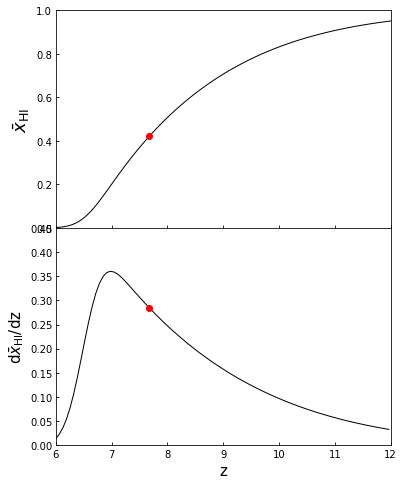

In [109]:
#plot the history of
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))
fig.subplots_adjust(hspace=0)   
axs[0].tick_params(direction='in',length=3)
axs[0].plot(z_HI_ana, HI_ana, color = 'black', lw=1, ls='-')
axs[0].plot(z_acc_array[6], HI_func(z_acc_array[6]), marker = 'o', color = 'red')
axs[0].set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=18)
axs[0].set_ylim(0,1)
#axs[0].legend(loc=2,fontsize=15, frameon = False)
axs[1].plot(z_dxHdz_ana, dxHdz_ana, color = 'black', lw=1, ls='-')
axs[1].plot(z_acc_array[6], dxHdz_acc_array[6], marker = 'o', color = 'red')
axs[1].set_ylim(0.0,0.45); axs[1].set_xlim(6,12)
axs[1].set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=15)
axs[1].set_xlabel('z',fontsize=15)
axs[1].tick_params(direction='in',length=3)
plt.savefig('../figures/history_comparison_confidence_redshift.png', bbox_inches='tight', dpi=200)

the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.451
the conputation cost 0.319 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 1.53
the conputation cost 0.313 mins


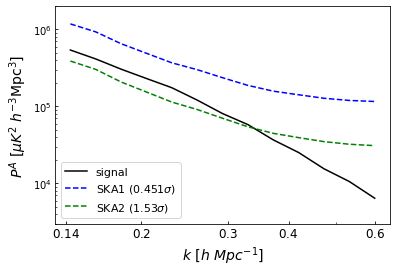

In [101]:
MODEL_PARA = [zeta, T_vir, R_mfp, zeta_z_func, z_HI_ana, HI_ana, z_dxHdz_ana, dxHdz_ana, HIrho_over_rho0_interp, BMF_interp, \
    xi_A_HICO_unsmoothed_interp]

DETECTION_PARA = [75, 3000*3600, 384]
Pk_A_acc, Pk_A_acc_var_0, S_over_N_0, kh_min_0, kh_max_0, confidence_0 = variance_computation(6, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, 0)
DETECTION_PARA = [200, 3000*3600, 384]
Pk_A_acc, Pk_A_acc_var_1, S_over_N_1, kh_min_1, kh_max_1, confidence_1 = variance_computation(6, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, 1)

#plot the signal and the variance
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)
axs.loglog(kh_array[3:], Pk_A_acc, color = 'black', label = 'signal')
axs.loglog(kh_array[3:], Pk_A_acc_var_0, ls = '--', color = 'blue', label = 'SKA1 (%3.3g$\sigma$)'%confidence_0)
axs.loglog(kh_array[3:], Pk_A_acc_var_1, ls = '--', color = 'green', label = 'SKA2 (%3.3g$\sigma$)'%confidence_1)
#axs.vlines(x=kh_max_array_2[INDEX_Z],ymin = 1e1,ymax = 1e7, color = 'grey', lw=0.8)
axs.legend(loc = 3, fontsize = 11)
#axs.set_ylim(0.0,0.46); axs.set_xlim(6,11)
axs.set_ylabel(r'$P^A\ [\mu K^2\ h^{-3} \mathrm{Mpc}^3]$',fontsize=14)
axs.set_xlabel(r'$k\ [h\ Mpc^{-1}]$',fontsize=14)
axs.tick_params(direction='in',length=3)
axs.set_ylim(3e3, 2e6)
axs.set_xticks([0.14, 0.2, 0.3,0.4, 0.6])
axs.set_xticklabels(['$0.14$', '$0.2$', '$0.3$', '$0.4$','$0.6$'], fontsize=12)
#axs[1].text(8.3, 0.31,'accel.',fontsize=12); axs[1].text(6.7, 0.3, 'decel.', fontsize = 12)
plt.savefig('../figures/sensitivity_z6.67_HI0.42_dxHdz0.285.png', bbox_inches='tight', dpi=200)

In [110]:
#compute the confidence dependence on the survey area
survey_num_array = np.logspace(np.log10(3), np.log10(200), 10)
confidence_array_0, confidence_array_1 = np.zeros(10), np.zeros(10)
for i in range(len(survey_num_array)):
    DETECTION_PARA = [survey_num_array[i], 3000*3600, 384]
    Pk_A_acc, Pk_A_acc_var_0, S_over_N_0, kh_min_0, kh_max_0, confidence_array_0[i] = variance_computation(6, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, 0)
    Pk_A_acc, Pk_A_acc_var_1, S_over_N_1, kh_min_0, kh_max_0, confidence_array_1[i] = variance_computation(6, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, 1)


the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.345
the conputation cost 0.325 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.468
the conputation cost 0.317 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.382
the conputation cost 0.336 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.575
the conputation cost 0.335 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.412
the conputation cost 0.349 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.697
the conputation cost 0.34 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.433
the conputation cost 0.366 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.865
the conputation cost 0.362 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.448
the conputation cost 0.36

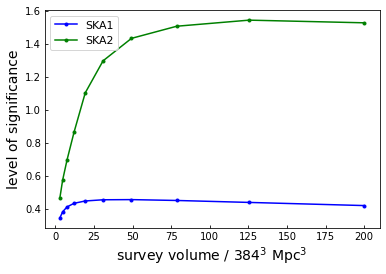

In [112]:
#plot the confidence dependence on the survey area
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)
axs.plot(survey_num_array, confidence_array_0, color = 'blue', marker = '.', label = 'SKA1')
axs.plot(survey_num_array, confidence_array_1, color = 'green', marker = '.', label = 'SKA2')
#axs.vlines(x=kh_max_array_2[INDEX_Z],ymin = 1e1,ymax = 1e7, color = 'grey', lw=0.8)
axs.legend(loc = 2, fontsize = 11)
#axs.set_ylim(0.0,0.46); axs.set_xlim(6,11)
axs.set_ylabel(r'level of significance',fontsize=14)
axs.set_xlabel(r'survey volume / $384^3 \ \mathrm{Mpc}^3$',fontsize=14)
axs.tick_params(direction='in',length=3)
#axs.set_xscale('log')
#axs.set_ylim(3e3, 2e6)
#axs.set_xticks([0.14, 0.2, 0.3,0.4, 0.6])
#axs.set_xticklabels(['$0.14$', '$0.2$', '$0.3$', '$0.4$','$0.6$'], fontsize=12)
plt.savefig('../figures/confidence_dependence_surveyarea.png', bbox_inches = 'tight', dpi=400)

In [95]:
#compute the confidence dependence on the survey area
t_int_array = np.logspace(np.log10(1000 * 3600), np.log10(16000 * 3600), 10)
confidence_array_0, confidence_array_1 = np.zeros(10), np.zeros(10)
for i in range(10):
    DETECTION_PARA = [100, t_int_array[i], 384]
    Pk_A_acc, Pk_A_acc_var_0, S_over_N_0, kh_min_0, kh_max_0, confidence_array_0[i] = variance_computation(6, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, 0)
    Pk_A_acc, Pk_A_acc_var_1, S_over_N_1, kh_min_0, kh_max_0, confidence_array_1[i] = variance_computation(6, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, 1)

the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.229
the conputation cost 0.325 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.798
the conputation cost 0.322 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.279
the conputation cost 0.336 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.93
the conputation cost 0.319 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.337
the conputation cost 0.318 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 1.07
the conputation cost 0.342 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.404
the conputation cost 0.328 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 1.31
the conputation cost 0.33 mins
the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 0.48
the conputation cost 0.311 mi

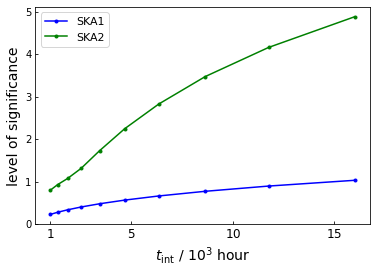

In [99]:
#plot the confidence dependence on the survey area
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)
axs.plot(t_int_array / 3600, confidence_array_0, color = 'blue', marker = '.', label = 'SKA1')
axs.plot(t_int_array / 3600, confidence_array_1, color = 'green', marker = '.', label = 'SKA2')
#axs.vlines(x=kh_max_array_2[INDEX_Z],ymin = 1e1,ymax = 1e7, color = 'grey', lw=0.8)
axs.legend(loc = 2, fontsize = 11)
#axs.set_ylim(0.0,0.46); axs.set_xlim(6,11)
axs.set_ylabel(r'level of significance',fontsize=14)
axs.set_xlabel(r'$t_\mathrm{int}$ ($10^3$ hour)',fontsize=14)
axs.tick_params(direction='in',length=3)
axs.set_xticks([1e3, 5e3, 10e3, 15e3])
axs.set_xticklabels(['$1$', '$5$', '$10$', '$15$'], fontsize=12)
plt.savefig('../figures/confidence_dependence_Tint.png', bbox_inches = 'tight', dpi=400)

In [127]:
#test
DETECTION_PARA = [800, 16000*3600, 250]
Pk_A_acc, Pk_A_acc_var_0, S_over_N_0, kh_min_0, kh_max_0, confidence_array_0 = variance_computation(6, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, 1)
confidence_array_0

the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 4.2
the conputation cost 0.3 mins


4.196721805029356

In [126]:
#test
DETECTION_PARA = [700, 16000*3600, 250]
Pk_A_acc, Pk_A_acc_var_0, S_over_N_0, kh_min_0, kh_max_0, confidence_array_0 = variance_computation(6, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, 1)
confidence_array_0

the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 4.17
the conputation cost 0.303 mins


4.169614373913648

In [125]:
#test
DETECTION_PARA = [600, 16000*3600, 250]
Pk_A_acc, Pk_A_acc_var_0, S_over_N_0, kh_min_0, kh_max_0, confidence_array_0 = variance_computation(6, z_acc_array, dxHdz_acc_array, kh_array, Pk_A_acc_map, MODEL_PARA, DETECTION_PARA, 1)
confidence_array_0

the confidence at z = 7.67, x_HI = 0.42, dxH/dz = 0.285 (acceleration) is 4.13
the conputation cost 0.354 mins


4.125651048159582